In [59]:
# import packages:
import numpy as np                   # Numeric Python
import matplotlib.pyplot as plt      # Plotting routines
import h5py                          # general HDF5 reading/writing library
import rioxarray as rx               # Package to read raster data from hdf5 files
from pyproj import Transformer, CRS  # libraries to allow coordinate transforms
import glob                          # Package to locate files on disk
import os                            # File-level utilities
import re                            # regular expressions for string interpretation
import icepyx as ipx                 # Package to interact with ICESat-2 online resources
from sliderule import icesat2        # Package for online ICESat-2 processing

In [60]:
%matplotlib inline

In [61]:
# logins, etc.

#HOST = 'https://urs.earthdata.nasa.gov'
#ipx.core.Earthdata.Earthdata('ben_smith','whatever@whatever.io', HOST).login()

url="icesat2sliderule.org"
icesat2.init(url, verbose=False)

In [62]:
# Annika's bounding box:
# x,y
#-340,-80
#-480,-170

XR= np.array([-480, -340])*1.e3
YR= np.array([-170, -80])*1.e3

# shrink down to a tiny box in the center:
XR=np.mean(XR)+np.array([-5.e3, 5.e3])
YR=np.mean(YR)+np.array([-5.e3, 5.e3])


# Prepare coordinate transformations between lat/lon and polar stereographic
crs=CRS.from_epsg(3031)
to_xy_crs=Transformer.from_crs(crs.geodetic_crs, crs)
to_geo_crs=Transformer.from_crs(crs, crs.geodetic_crs)

corners_lat, corners_lon=to_geo_crs.transform(np.array(XR)[[0, 1, 1, 0, 0]], np.array(YR)[[0, 0, 1, 1, 0]])
latlims=[np.min(corners_lat), np.max(corners_lat)]
lonlims=[np.min(corners_lon), np.max(corners_lon)]

In [63]:
# run a slideRule ATL06 query.  Just ask for cycle 8 (Antarctic winter, 2020)
# to avoid getting swamped right away

# See parameters here:
# http://icesat2sliderule.org/rtd/user_guide/ICESat-2.html
params= { 'poly':[{'lon':this_lon, 'lat':this_lat} for this_lon, this_lat in zip(corners_lon, corners_lat)],
        'srt':3,
        'cnf':1,
        'len':10,
         'res':10,
         'ats':5,
         'cnt':10,
         'cycle':8,
         'maxi': 10,
        'pass_invalid':False}

D_IS_SR=icesat2.atl06p(params, 
                     asset="nsidc-s3")

In [64]:
#D_IS_SR[0:100]

In [65]:
D_IS_SR.n_fit_photons .count()

59002

In [66]:
# even spots = weak beams
D_IS_SR_even_spots = D_IS_SR[(D_IS_SR.spot % 2==0)]

In [67]:
# odd spots = strong beams
D_IS_SR_odd_spots = D_IS_SR[(D_IS_SR.spot % 2!=0)]

In [68]:
#Preview
#D_IS_SR_even_spots.head(3)
#D_IS_SR_odd_spots.head(3)

In [69]:
print("All:",D_IS_SR['n_fit_photons'].count())
print("Even spots:",D_IS_SR_even_spots['n_fit_photons'].count())
print("Odd spots:",D_IS_SR_odd_spots['n_fit_photons'].count())

All: 59002
Even spots: 27011
Odd spots: 31991


In [70]:
lon=np.array([gi.x for gi in D_IS_SR.geometry])
lat=np.array([gi.y for gi in D_IS_SR.geometry])
xy=to_xy_crs.transform(lat, lon)

In [71]:
#lon_e=np.array([gi.x for gi in D_IS_SR_even_spots.geometry])
#lat_e=np.array([gi.y for gi in D_IS_SR_even_spots.geometry])
#xy_e=to_xy_crs.transform(lat_e, lon_e)

In [72]:
lon_o=np.array([gi.x for gi in D_IS_SR_odd_spots.geometry])
lat_o=np.array([gi.y for gi in D_IS_SR_odd_spots.geometry])
xy_o=to_xy_crs.transform(lat_o, lon_o)

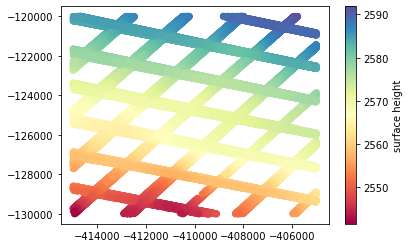

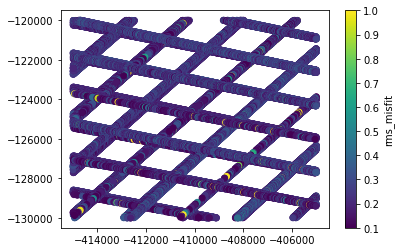

In [73]:
# All beams
plt.figure(); plt.scatter(xy[0], xy[1], c=D_IS_SR['h_mean'], cmap='Spectral'); plt.colorbar(label='surface height')
plt.figure(); plt.scatter(xy[0], xy[1], c=D_IS_SR['rms_misfit'], vmin=0.1, vmax=1); plt.colorbar(label='rms_misfit')

In [74]:
# Weak beam (even spot number)
#plt.figure(); plt.scatter(xy_e[0], xy_e[1], c=D_IS_SR_even_spots['h_mean'], cmap='Spectral'); plt.colorbar(label='surface height')
#plt.figure(); plt.scatter(xy_e[0], xy_e[1], c=D_IS_SR_even_spots['rms_misfit'], vmin=0.1, vmax=1); plt.colorbar(label='rms_misfit')

#plt.figure(); plt.hist(D_IS_SR_even_spots['rms_misfit'], np.arange(0, 2, 0.01));

#sigma_extra_e=np.sqrt(np.maximum(0, D_IS_SR_even_spots['rms_misfit']**2-(0.68e-9*1.5e8)**2))
#plt.figure(); plt.hist(sigma_extra_e, np.arange(0, .5, 0.01));

#plt.figure(); plt.scatter(xy_e[0], xy_e[1], c=sigma_extra_e, vmin=0, vmax=0.5); plt.colorbar(label='roughness?')

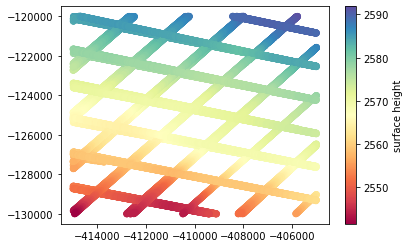

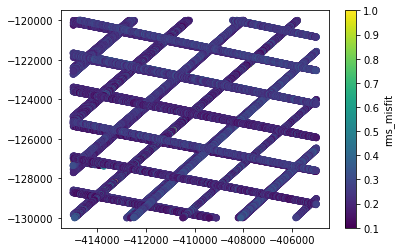

In [75]:
# Strong beams (odd spot number)
plt.figure(); plt.scatter(xy_o[0], xy_o[1], c=D_IS_SR_odd_spots['h_mean'], cmap='Spectral'); plt.colorbar(label='surface height')
plt.figure(); plt.scatter(xy_o[0], xy_o[1], c=D_IS_SR_odd_spots['rms_misfit'], vmin=0.1, vmax=1); plt.colorbar(label='rms_misfit')

In [76]:
#f, axa = plt.subplots(1,2,figsize=(10,3))
#plt.scatter(xy[0], xy[1], c=D_IS_SR['h_mean'], cmap='Spectral'); 
#axa[0].colorbar(label='surface height', ax=axa[0])
#axa[0].set_title('ALL')
#f.colorbar(m, ax=axa[0])
#f.colorbar(m, ax=axa[1]);

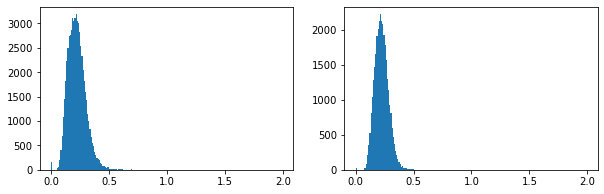

In [77]:
f, axa = plt.subplots(1,2,figsize=(10,3))
axa[0].hist(D_IS_SR['rms_misfit'], np.arange(0, 2, 0.01))
axa[1].hist(D_IS_SR_odd_spots['rms_misfit'], np.arange(0, 2, 0.01));

In [78]:
#plt.figure(); plt.hist(D_IS_SR['rms_misfit'], np.arange(0, 2, 0.01));

In [79]:
#plt.figure(); plt.hist(D_IS_SR_odd_spots['rms_misfit'], np.arange(0, 2, 0.01));

In [80]:
sigma_extra=np.sqrt(np.maximum(0, D_IS_SR['rms_misfit']**2-(0.68e-9*1.5e8)**2))
D_IS_SR_odd_spots['sigma_extra_o']=np.sqrt(np.maximum(0, D_IS_SR_odd_spots['rms_misfit']**2-(0.68e-9*1.5e8)**2))

/srv/conda/envs/notebook/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


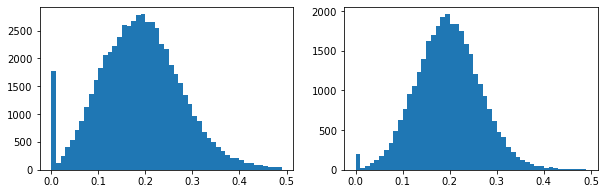

In [81]:
f, axa = plt.subplots(1,2,figsize=(10,3))
axa[0].hist(sigma_extra, np.arange(0, .5, 0.01));
axa[1].hist(D_IS_SR_odd_spots['sigma_extra_o'], np.arange(0, .5, 0.01));

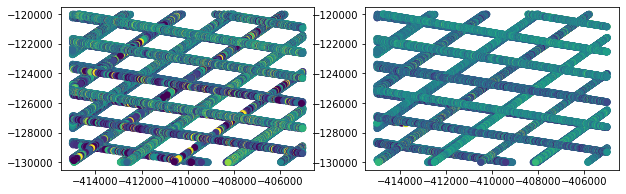

In [82]:
f, axa = plt.subplots(1,2,figsize=(10,3))
axa[0].scatter(xy[0], xy[1], c=sigma_extra, vmin=0, vmax=0.5); 
axa[1].scatter(xy_o[0], xy_o[1], c=D_IS_SR_odd_spots['sigma_extra_o'], vmin=0, vmax=0.5);

In [83]:
#plt.figure();plt.scatter(xy_o[0], xy_o[1], c=D_IS_SR_odd_spots['sigma_extra_o'], vmin=0, vmax=0.5); plt.colorbar(label='roughness?')

In [84]:
#plt.figure(); plt.hist(sigma_extra_o, np.arange(0, .5, 0.01));
# Aim to remove the peak near 0.0--->look at sigma_extra_o

In [85]:
D_IS_SR_odd_spots['sigma_extra_o'] = np.sqrt(np.maximum(0, D_IS_SR_odd_spots['rms_misfit']**2-(0.68e-9*1.5e8)**2))

In [86]:
D_IS_SR_odd_spots.n_fit_photons.count()

31991

In [87]:
D_IS_SR_odd_spots[D_IS_SR_odd_spots['sigma_extra_o']==0].n_fit_photons.count()

186

In [88]:
# filter the data based on sigma_extra_o
D_IS_SR_odd_spots_corrected = D_IS_SR_odd_spots[D_IS_SR_odd_spots['sigma_extra_o']!=0]

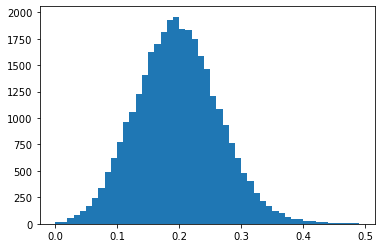

In [89]:
plt.figure(); plt.hist(D_IS_SR_odd_spots_corrected['sigma_extra_o'], np.arange(0, .5, 0.01));

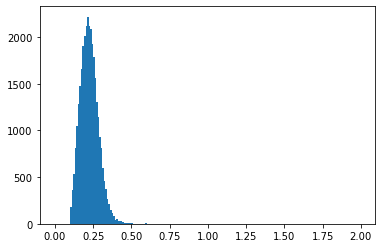

In [90]:
# RMS (not sigma_extra) fit for corrected odd spots data and sigma_extra==0
plt.figure(); plt.hist(D_IS_SR_odd_spots_corrected['rms_misfit'], np.arange(0, 2, 0.01));

In [91]:
# sigma_extra!=0
D_IS_SR_odd_spots_corrected.head(3)

,delta_time,cycle,rms_misfit,gt,dh_fit_dy,h_mean,distance,pflags,spot,w_surface_window_final,h_sigma,dh_fit_dx,segment_id,rgt,n_fit_photons,geometry,sigma_extra_o
time,,,,,,,,,,,,,,,,,
2020-06-25 19:01:36.330265552,7.834690e+07,8,0.244093,10,0.0,2587.747252,3.048879e+07,0,5,3.0,0.02192,-0.028466,1523665,6,124,POINT (-106.30057 -86.06635),0.221759
2020-06-25 19:01:36.331686384,7.834690e+07,8,0.198407,10,0.0,2587.665630,3.048880e+07,0,5,3.0,0.01749,-0.006035,1523666,6,129,POINT (-106.30122 -86.06627),0.170180
2020-06-25 19:01:36.333092992,7.834690e+07,8,0.197029,10,0.0,2587.707502,3.048881e+07,0,5,3.0,0.01911,0.018254,1523666,6,109,POINT (-106.30187 -86.06619),0.168571


In [92]:
# Dataframe with spot = odd numbers
D_IS_SR_odd_spots[D_IS_SR_odd_spots['n_fit_photons']<=100].n_fit_photons.count()

19600

In [93]:
# Checking the peak around 0 for sigma_extra in the dataframe
D_IS_SR_odd_spots[D_IS_SR_odd_spots['sigma_extra_o']==0].n_fit_photons.count()

186

In [94]:
# Dataframe with sigma_extra=0 values removed 
D_IS_SR_odd_spots_corrected[D_IS_SR_odd_spots_corrected['n_fit_photons']<100].n_fit_photons.count()

18916

In [95]:
# Dataframe with sigma_extra=0 values removed 
D_IS_SR_odd_spots_corrected[D_IS_SR_odd_spots_corrected['n_fit_photons']<=100].n_fit_photons.count()
# does it show that all of 186 points are less than 100 but we have more points that are less than 100? 
#not from the graphs

19414

In [96]:
# filter the data based on no of photons and spot 
D_IS_SR_odd_spots_p100 = D_IS_SR_odd_spots[D_IS_SR_odd_spots['n_fit_photons']>100]

In [97]:
D_IS_SR_odd_spots_p100['n_fit_photons'].count()

12391

In [98]:
D_IS_SR_odd_spots_p100[D_IS_SR_odd_spots_p100['sigma_extra_o']==0].n_fit_photons.count()

0

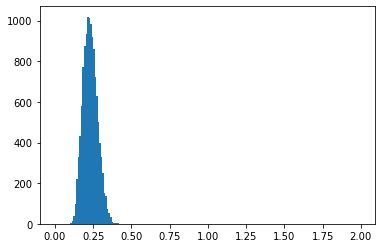

In [99]:
# RMS fit for odd spots dataframe corrected (i.e. spot =odd, no. of photons>100)
plt.figure(); plt.hist(D_IS_SR_odd_spots_p100['rms_misfit'], np.arange(0, 2, 0.01));

In [100]:
D_IS_SR_odd_spots_p100['rms_misfit'].max()

0.4397246412384308

In [101]:
# filter the data based on no of photons, spot and sigma_extra!=0
D_IS_SR_odd_spots_p100_corrected = D_IS_SR_odd_spots_p100[D_IS_SR_odd_spots_p100['sigma_extra_o']!=0]

In [102]:
D_IS_SR_odd_spots_p100_corrected['n_fit_photons'].count()

12391

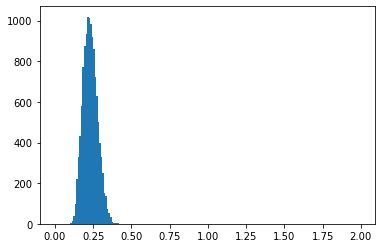

In [103]:
# RMS fit for odd spots dataframe corrected (i.e. spot =odd, no. of photons>100, sigma_extra=0)
plt.figure(); plt.hist(D_IS_SR_odd_spots_p100_corrected['rms_misfit'], np.arange(0, 2, 0.01));

In [104]:
D_IS_SR_odd_spots_p100_corrected['rms_misfit'].max()

0.4397246412384308

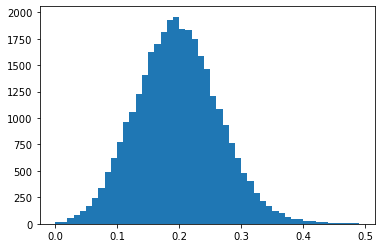

In [105]:
plt.figure(); plt.hist(D_IS_SR_odd_spots_corrected['sigma_extra_o'], np.arange(0, .5, 0.01));

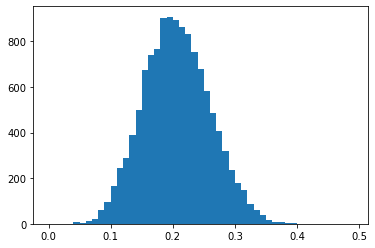

In [106]:
plt.figure(); plt.hist(D_IS_SR_odd_spots_p100['sigma_extra_o'], np.arange(0, .5, 0.01));

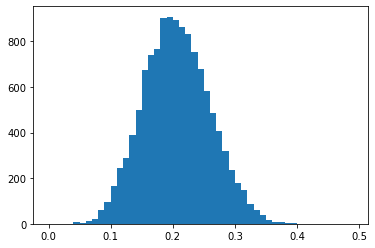

In [107]:
plt.figure(); plt.hist(D_IS_SR_odd_spots_p100_corrected['sigma_extra_o'], np.arange(0, .5, 0.01));

In [108]:
#pip install seaborn

In [109]:
import seaborn as sns

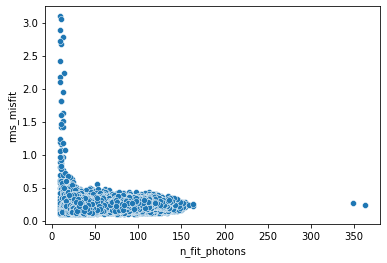

In [110]:
sns.scatterplot(x="n_fit_photons", y="rms_misfit", data=D_IS_SR_odd_spots_corrected);

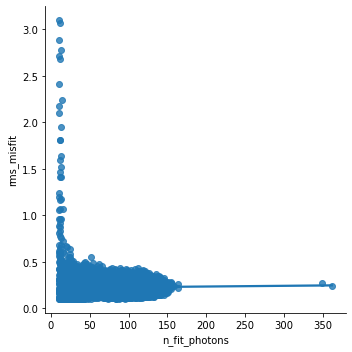

In [111]:
#Best fit line -- datafframe corrected (i.e. spot =odd, sigma_extra>0)
sns.lmplot(x="n_fit_photons", y="rms_misfit", data=D_IS_SR_odd_spots_corrected);

In [112]:
from scipy import stats
stats.pearsonr(D_IS_SR_odd_spots_corrected['n_fit_photons'], D_IS_SR_odd_spots_corrected['rms_misfit'])

(0.03252494118628063, 6.561042239107935e-09)

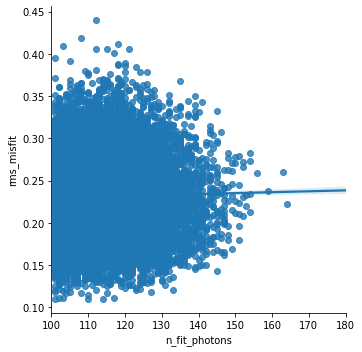

In [113]:
#Best fit line -- dataframe corrected (i.e. spot =odd, no. of photons>100)
sns.lmplot(x="n_fit_photons", y="rms_misfit", data=D_IS_SR_odd_spots_p100)
plt.xlim([100,180]);

In [114]:
stats.pearsonr(D_IS_SR_odd_spots_p100['n_fit_photons'], D_IS_SR_odd_spots_p100['rms_misfit'])

(0.024508521441100037, 0.006366218478766558)

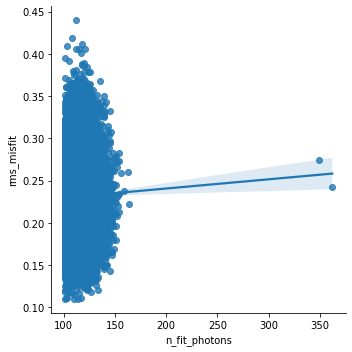

In [115]:
 #Best fit line -- datafframe corrected (i.e. spot =odd, sigma_extra>0)
sns.lmplot(x="n_fit_photons", y="rms_misfit", data=D_IS_SR_odd_spots_p100_corrected);

In [116]:
stats.pearsonr(D_IS_SR_odd_spots_p100_corrected['n_fit_photons'], D_IS_SR_odd_spots_p100_corrected['rms_misfit'])

(0.024508521441100037, 0.006366218478766558)

In [117]:
D_IS_SR_odd_spots_p100_corrected.head(3)

,delta_time,cycle,rms_misfit,gt,dh_fit_dy,h_mean,distance,pflags,spot,w_surface_window_final,h_sigma,dh_fit_dx,segment_id,rgt,n_fit_photons,geometry,sigma_extra_o
time,,,,,,,,,,,,,,,,,
2020-06-25 19:01:36.330265552,7.834690e+07,8,0.244093,10,0.0,2587.747252,3.048879e+07,0,5,3.0,0.02192,-0.028466,1523665,6,124,POINT (-106.30057 -86.06635),0.221759
2020-06-25 19:01:36.331686384,7.834690e+07,8,0.198407,10,0.0,2587.665630,3.048880e+07,0,5,3.0,0.01749,-0.006035,1523666,6,129,POINT (-106.30122 -86.06627),0.170180
2020-06-25 19:01:36.333092992,7.834690e+07,8,0.197029,10,0.0,2587.707502,3.048881e+07,0,5,3.0,0.01911,0.018254,1523666,6,109,POINT (-106.30187 -86.06619),0.168571


In [118]:
#D_IS_SR_odd_spots_p100_corrected

In [120]:
# checking correlation
cormat = D_IS_SR_odd_spots_p100_corrected.corr()
round(cormat,2)

,delta_time,cycle,rms_misfit,gt,dh_fit_dy,h_mean,distance,pflags,spot,w_surface_window_final,h_sigma,dh_fit_dx,segment_id,rgt,n_fit_photons,sigma_extra_o
delta_time,1.00,NaN,0.28,0.27,NaN,0.15,-0.09,NaN,-0.27,NaN,0.27,0.01,-0.09,1.00,-0.03,0.27
cycle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rms_misfit,0.28,NaN,1.00,0.13,NaN,0.01,0.19,NaN,-0.13,NaN,0.98,-0.03,0.19,0.28,0.02,1.00
gt,0.27,NaN,0.13,1.00,NaN,-0.26,-0.21,NaN,-1.00,NaN,0.17,0.02,-0.21,0.27,-0.25,0.12
dh_fit_dy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
h_mean,0.15,NaN,0.01,-0.26,NaN,1.00,-0.04,NaN,0.26,NaN,-0.01,0.02,-0.04,0.15,0.09,0.01
distance,-0.09,NaN,0.19,-0.21,NaN,-0.04,1.00,NaN,0.21,NaN,0.22,-0.13,1.00,-0.09,-0.13,0.19
pflags,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
spot,-0.27,NaN,-0.13,-1.00,NaN,0.26,0.21,NaN,1.00,NaN,-0.17,-0.02,0.21,-0.27,0.25,-0.12
w_surface_window_final,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


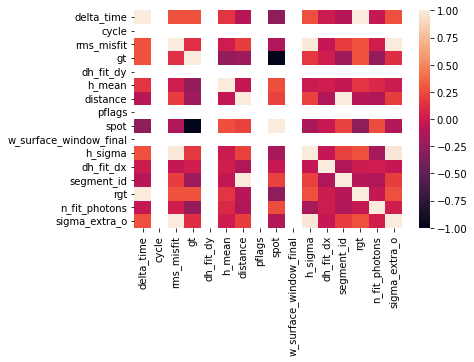

In [122]:
sns.heatmap(cormat);